In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from matplotlib.font_manager import FontProperties
from imblearn.over_sampling import ADASYN

In [2]:
# Data Import
df = pd.read_csv("winequality-red.csv")

In [ ]:
df.describe()

#
**Contextualization**

- Measurements of 11 physical-chemical variables that characterize each sample (the features of the problem):
<br>
  - 1 - fixed acidity - measurement of acidity due to the presence of low-volatility organic acids (malic, lactic, tartaric or citric acid);
  - 2 - volatile acidity - measurement of acidity due to the presence of low molecular weight acids (mainly acetic acid), which are responsible for the vinegar aroma and taste;
  - 3 - citric acid - measurement of citric acid;
  - 4 - residual sugar - measurement of residual sugar present, originating from the sugar residues of the grape that remain after the end of fermentation;
  - 5 - chlorides - measurement of chlorides (chlorine ions);
  - 6 - free sulfur dioxide - measurement of free sulfur dioxide (i.e., that which is not bound to other molecules); - 7 - total sulfur dioxide - measure of total sulfur dioxide (free + portion bound to other molecules);
  - 8 - density - measure of the density of the wine;
  - 9 - pH - measure of the pH of the wine;
  - 10 - sulphates - measure of sulfates (SO₄²⁻ ions);
  - 11 - alcohol - measure of the alcoholic strength.
  - 12 - quality - numerical quality score (from 3 to 8), produced based on sensory data.

#
1. The main descriptive statistics of position (mean, median, quartiles etc.) and dispersion (std, IQR etc.)

In [7]:
df_desc = df.describe()

In [8]:
df_desc.loc["IQR"] = df_desc.loc["75%"] - df_desc.loc["25%"]

#
2. Presence of outliers

In [ ]:
for col in df:
  plt.figure(figsize=(4,4))
  sns.histplot(data=df, x=col, kde=True).set_title(f"Variable distribution: {col}")
  plt.show()

In [ ]:
## Método do Quartil.

for col in df.drop(columns='quality'):
    
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  
  aux_outliers = df[
    (df[col] < Q1-(IQR*1.5)) |
    (df[col] > Q3+(IQR*1.5))
  ]
  
  indices_outliers = aux_outliers.index.tolist()
  
  if len(indices_outliers) >= 1:
      
    print(f"The column {col} has {len(indices_outliers)} outliers!")
    print("\nIts indexes are:\n")
    print(indices_outliers)

  else:
      
    print(f"The column {col} has not outliers!")
      
  print()
  print("="*80)
  print()

#
1. Bar graph of the 90% confidence interval for the mean of each of the physical-chemical variables, grouped by the categorical levels of the response variable quality.

In [28]:
df["fixed acidity"].mean()

8.31963727329581

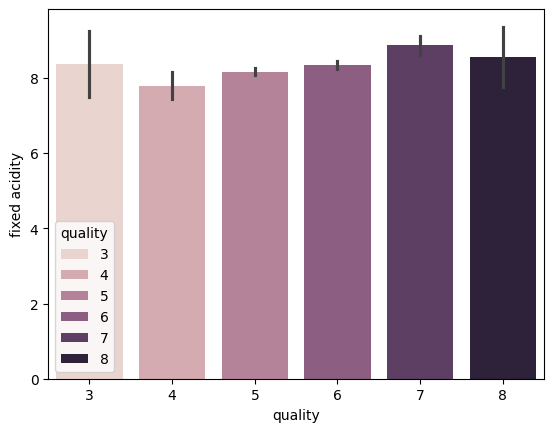

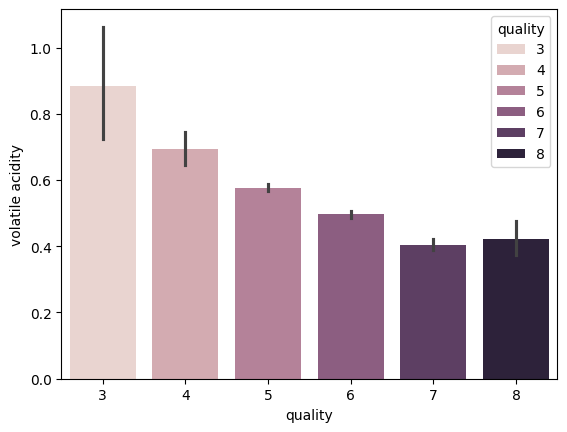

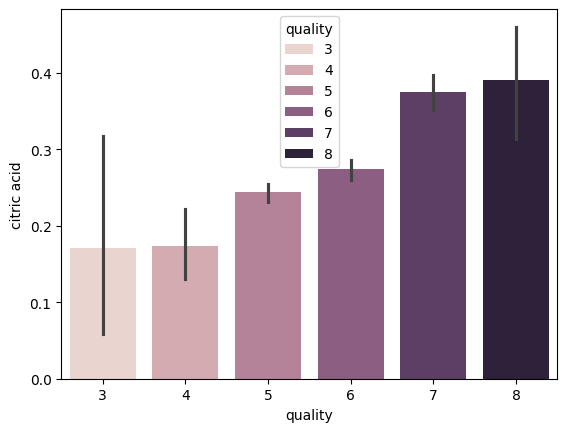

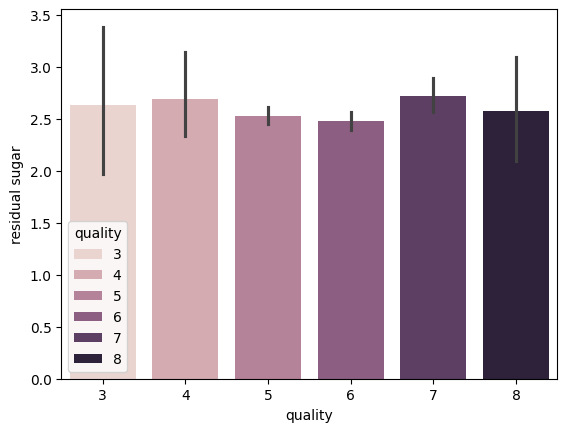

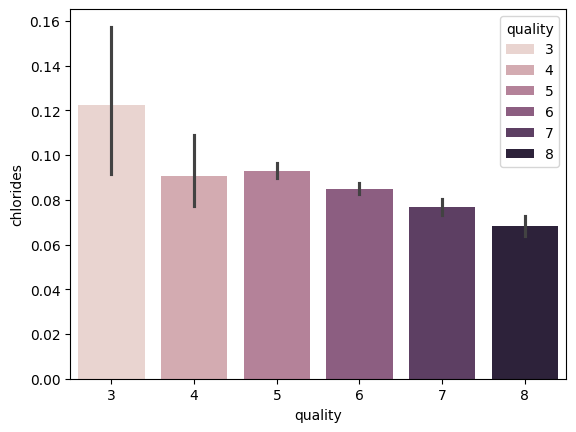

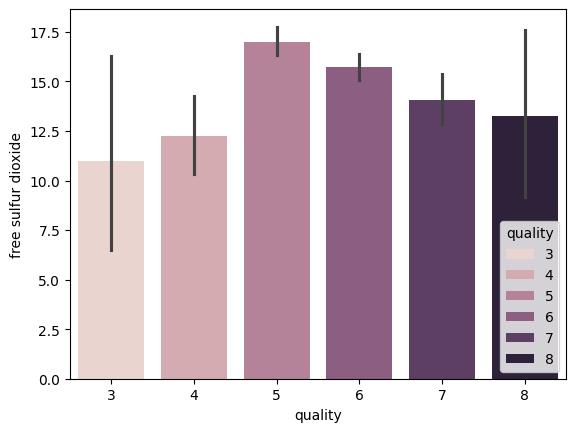

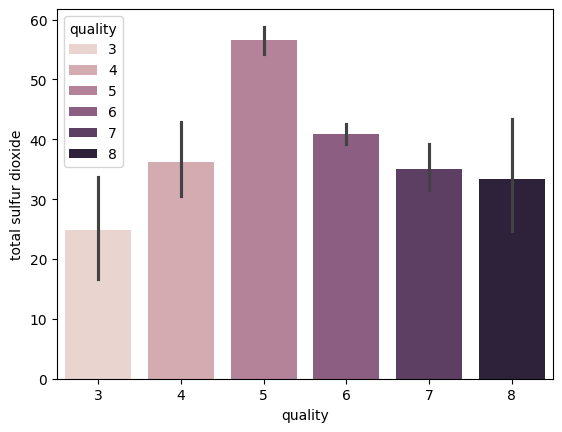

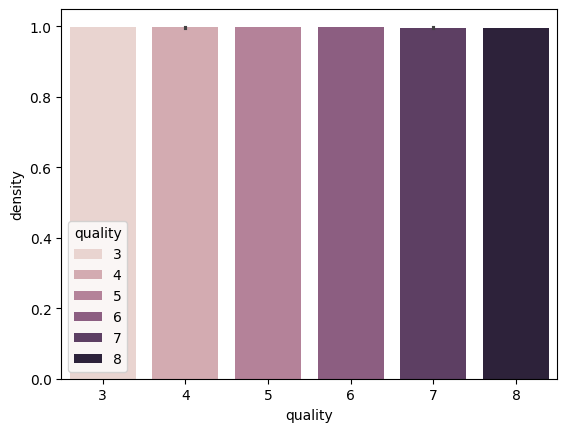

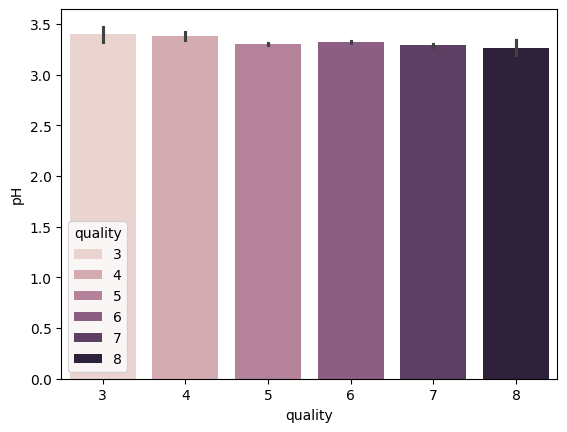

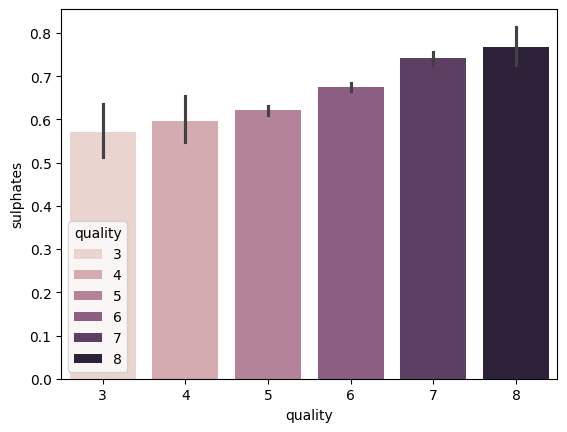

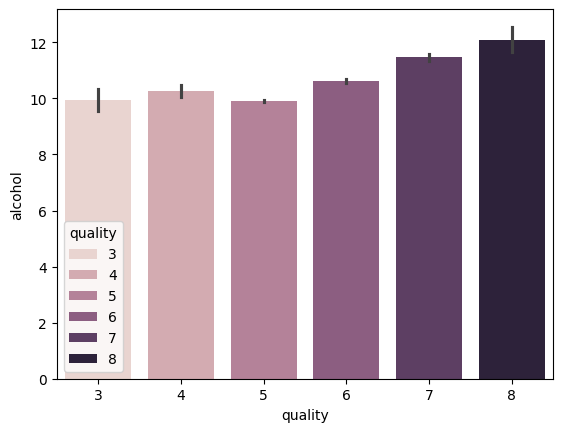

In [31]:
# 
for col in df.drop(columns="quality"):
  sns.barplot(data=df, x="quality", y=col, errorbar=("ci", 90), hue="quality")
  plt.show()

In [27]:
df['quality_bin'] = df['quality'].apply(lambda x : "bom" if x > 5 else "ruim")

In [ ]:
df_bin = df.drop(columns=['quality'])
df_bin

In [ ]:
for col in df_bin.drop(columns='quality_bin'):
  sns.histplot(
    data=df_bin, x=col, kde=True, hue=df_bin['quality_bin']
    ).set_title(f"Distribuição da variável {col}")
  plt.show()

#
5. Machine Learning

In [ ]:
# Correlation plot
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True)
plt.title(
  "Correlation".upper(),
  fontdict={'family':'calibri', 'fontsize':18, 'weight':'bold', 'color':'red'},
  pad=20
)
plt.show()

In [ ]:
print("Correlation with quality column:".center(50).upper())
print()
for col in df.drop(columns="quality").columns:
  print(f"{col}: {df["quality"].corr(df[col]):.4f}")

In [ ]:
# Division between independent and dependent variables
X = df.drop(columns=["quality"]).values
y = df["quality"].values

In [ ]:
# Building ADASYN
adasyn = ADASYN(
  sampling_strategy='minority',
  random_state=42,
  n_neighbors=5
)

# Applying ADASYN to balance the dataset
X_resampled, y_resampled = adasyn.fit_resample(X, y)

In [ ]:
# Data split for training and testing 70/30
X_train, X_test, y_train, y_test = train_test_split(
  X_resampled, y_resampled, test_size=0.3, random_state=42
)

##
RandomForestClassifier

In [ ]:
# Building RandomForest Model
clf_rf = RandomForestClassifier(random_state=42)

# Training the model
clf_rf.fit(X_train, y_train)

# Making predictions
y_pred_rf = clf_rf.predict(X_test)

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Model Accuracy
accuracy_rf = clf_rf.score(X_test, y_test)

In [ ]:
# Evaluating the model
print("Model Accuracy:")
print(f"{round(accuracy_rf * 100,2)}%")
print()
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

##
RandomForestClassifier c/ GridSearchCV

In [ ]:
# Hyperparameters for testing
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
# Building model with GridSearchCV and RandomForestClassifier
grid_search = GridSearchCV(
  estimator=RandomForestClassifier(random_state=42),
  param_grid=param_grid,
  cv=5, n_jobs=-1,
  scoring='precision'
)

# Tuning GridSearchCV to training data
grid_search.fit(X_train, y_train)

# Getting the best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")

In [ ]:
# Getting the best model
best_clf = grid_search.best_estimator_

# Making predictions
y_pred = best_clf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Model Accuracy
accuracy = best_clf.score(X_test, y_test)

In [ ]:
# Evaluating the Model
print("Model Accuracy:")
print(f"{round(accuracy * 100,2)}%")
print()
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

##
Plot Confusion Matrix

In [ ]:
# TickLabel font for the confusion matrix plot
font_ticklabels = FontProperties(
  family='calibri', size=12, weight='bold')

In [ ]:
# Ploting the Confusion Matrix without GridSearchCV
plt.figure(figsize=(10, 7))
ax_rf = sns.heatmap(
  cm_rf,
  annot=True,
  fmt='d',
  cmap='Blues',
  xticklabels=set(y_train),
  yticklabels=set(y_train)
)

plt.xticks(fontproperties=font_ticklabels)
plt.yticks(fontproperties=font_ticklabels)


plt.xlabel('Predicted', fontdict={'fontsize':14}, labelpad=20)
plt.ylabel('Actual', fontdict={'fontsize':14}, labelpad=20)
plt.title('Confusion Matrix Without GridSearchCV', fontdict={'fontsize':16})
plt.show();

In [ ]:
# Ploting the Confusion Matrix with GridSearchCV
plt.figure(figsize=(10, 7))
ax = sns.heatmap(
  cm,
  annot=True,
  fmt='d',
  cmap='Blues',
  xticklabels=set(y_train),
  yticklabels=set(y_train)
)

plt.xticks(fontproperties=font_ticklabels)
plt.yticks(fontproperties=font_ticklabels)

plt.xlabel('Predicted', fontdict={'fontsize':14}, labelpad=20)
plt.ylabel('Actual', fontdict={'fontsize':14}, labelpad=20)
plt.title('Confusion Matrix with GridSearch', fontdict={'fontsize':16})
plt.show();

In [ ]:
# dataframe index
df_index = [x[0] for x in pd.DataFrame(y_test).value_counts().keys()]

# Dataframe with the number of forecasts and test data
pd.DataFrame(
  zip(
    pd.DataFrame(y_pred_rf).value_counts(),
    pd.DataFrame(y_pred).value_counts(),
    pd.DataFrame(y_test).value_counts()
    ),
  columns=["Pred_Grid", "Pred", "Test"],
  index=df_index
)

In [ ]:
# Dataframe with the forecasts and test data
df_pred = pd.DataFrame(
  zip(y_pred_rf, y_pred, y_test),
  columns=["Pred_Grid", "Pred", "Test"]
)

In [ ]:
print(f"Amount of test data: {df_pred.shape[0]}")
print(
  "Accurate predictions with GridSearchCV:",
  df_pred[df_pred["Pred_Grid"] == df_pred["Test"]].shape[0]
)
print(
  "Accurate predictions without GridSearchCV:",
  df_pred[df_pred["Pred"] == df_pred["Test"]].shape[0]
)